# **Problem Statement**

The Indian software industry shows large variations in salary across roles, locations, and experience levels.
However, it is unclear which factors contribute most significantly to salary differences and whether these differences are statistically meaningful.

**Objective**

This project aims to analyze Indian software industry salary data to:

1. Identify key factors influencing salary (experience, location, role).
2. Examine salary distribution and inequality across cities and roles.
3. Validate observed salary differences using statistical methods.
4. Build a baseline predictive model to estimate salary based on key     features.






# **Key Analytical Questions**


1. Does location or experience have a stronger impact on salary?
2. Are salaries in Tier-1 cities significantly higher than Tier-2 cities?
3. Is the salary distribution skewed or balanced?
4. Do some roles show diminishing salary growth after a certain experience?
5. Can salary be reasonably predicted using available features?



**Dataset Description**

The dataset contains salary information for professionals in the Indian software industry.
It includes attributes such as job role, years of experience, location, and annual salary.
The data is used to analyze salary trends and disparities across different factors.

In [ ]:
import pandas as pd
df = pd.read_csv("Software_Professional_Salaries.csv")
df.shape
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22774 entries, 0 to 22773
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             22774 non-null  float64
 1   Company Name       22773 non-null  object 
 2   Job Title          22774 non-null  object 
 3   Salary             22774 non-null  int64  
 4   Salaries Reported  22774 non-null  int64  
 5   Location           22774 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.0+ MB


,Rating,Salary,Salaries Reported
count,22774.000000,2.277400e+04,22774.000000
mean,3.918249,6.953606e+05,1.855625
std,0.519676,8.843263e+05,6.823078
min,1.000000,2.112000e+03,1.000000
25%,3.700000,3.000000e+05,1.000000
50%,3.900000,5.000000e+05,1.000000
75%,4.200000,9.000000e+05,1.000000
max,5.000000,9.000000e+07,361.000000


In [ ]:
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

# Data Cleaning
Missing values in the company_name column were retained, as this feature is not central to salary-based analysis.
No imputation was performed to avoid introducing artificial information.

In [ ]:
df.columns

Index(['Rating', 'Company Name', 'Job Title', 'Salary', 'Salaries Reported',
       'Location'],
      dtype='object')

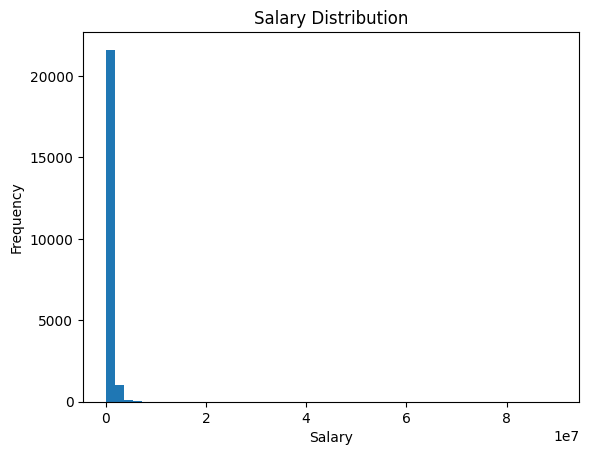

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['Salary'], bins=50)
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.title("Salary Distribution")
plt.show()

“To address skewness in salary data, a logarithmic scale was used for visualization, while percentile-based outlier removal was applied for statistical analysis.”

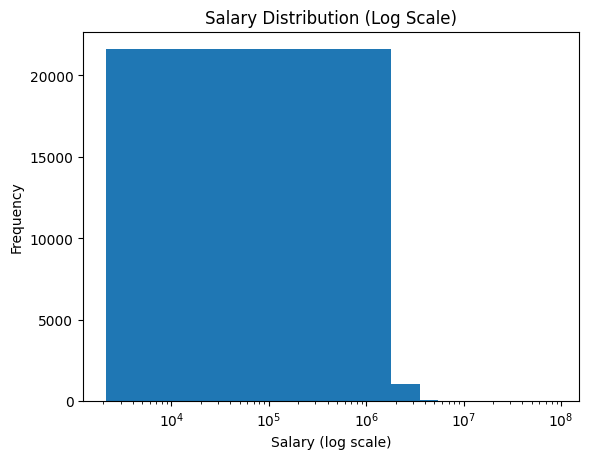

In [ ]:
plt.hist(df['Salary'], bins=50)
plt.xscale('log')
plt.xlabel("Salary (log scale)")
plt.ylabel("Frequency")
plt.title("Salary Distribution (Log Scale)")
plt.show()

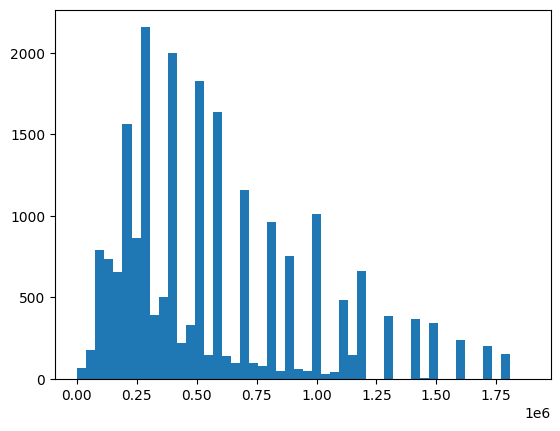

In [ ]:
filtered_salary = df[df['Salary'] < df['Salary'].quantile(0.95)]
plt.hist(filtered_salary['Salary'], bins=50)
plt.show()


# Does location significantly affect salary?

In [ ]:
location_salary = (
    df.groupby('Location')['Salary']
      .agg(['count', 'median', 'mean'])
      .sort_values(by='median', ascending=False)
)

location_salary.head(10)

,count,median,mean
Location,,,
Mumbai,749,708000.0,961180.368491
Bangalore,8265,500000.0,735352.562371
Kolkata,178,500000.0,710925.573034
Hyderabad,4468,500000.0,679036.691137
Kerala,108,500000.0,553577.481481
Jaipur,82,500000.0,628487.804878
New Delhi,4176,500000.0,658756.735632
Madhya Pradesh,155,500000.0,677641.909677
Pune,2135,500000.0,690340.256674


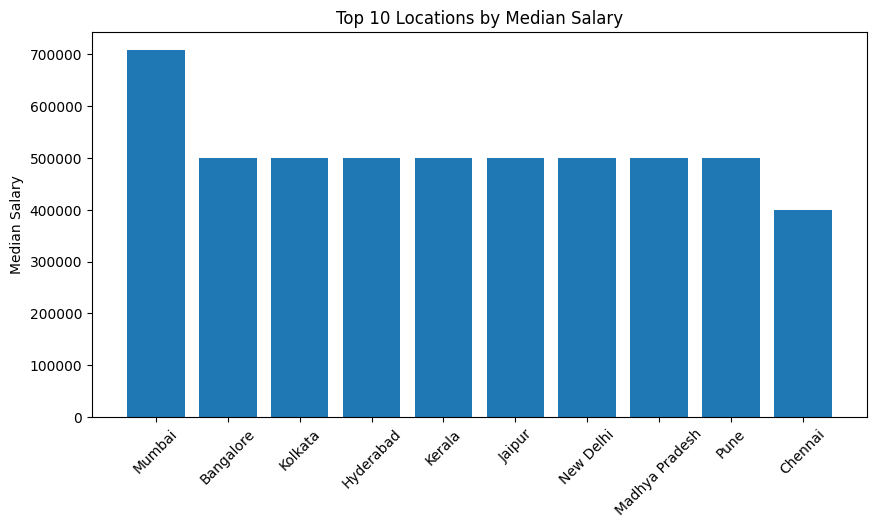

In [ ]:
top_locations = location_salary.head(10).reset_index()

plt.figure(figsize=(10,5))
plt.bar(top_locations['Location'], top_locations['median'])
plt.xticks(rotation=45)
plt.ylabel("Median Salary")
plt.title("Top 10 Locations by Median Salary")
plt.show()

Locations such as Mumbai,Banglore and Kolkata show higher median salaries compared to other regions.
This suggests that geographical location plays a significant role in salary determination, likely due to cost of living and concentration of high-paying firms.

# Do different job roles show unequal salary distributions?

In [ ]:
role_salary = (
    df.groupby('Job Title')['Salary']
      .agg(['count', 'median'])
      .sort_values(by='count', ascending=False)
)

top_roles = role_salary.head(10).reset_index()
top_roles

,Job Title,count,median
0,Software Development Engineer,2351,600000.0
1,Android Developer,2029,400000.0
2,Software Development Engineer (SDE),1614,700000.0
3,Front End Developer,1412,480000.0
4,Test Engineer,1314,400000.0
5,Web Developer,853,324000.0
6,Software Development Engineer - Intern,771,324000.0
7,Software Development Engineer In Test (SDET),766,624000.0
8,Backend Developer,534,500000.0
9,Python Developer,485,400000.0


<Figure size 1200x600 with 0 Axes>

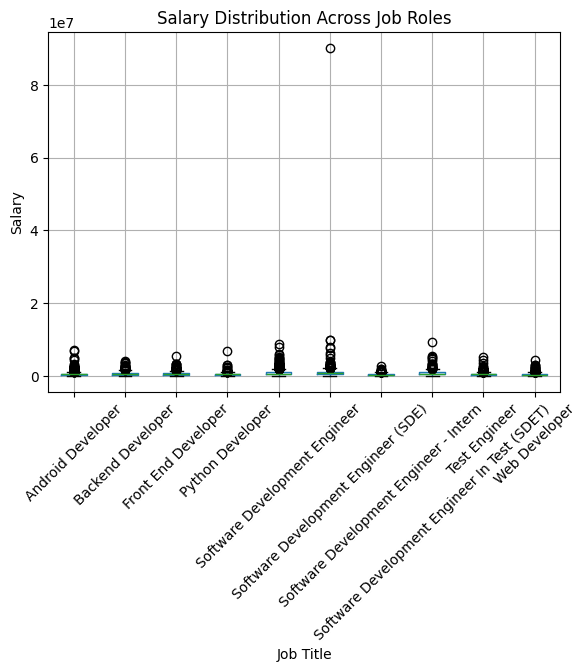

In [ ]:
plt.figure(figsize=(12,6))
df[df['Job Title'].isin(top_roles['Job Title'])].boxplot(
    column='Salary',
    by='Job Title',
    rot=45
)
plt.title("Salary Distribution Across Job Roles")
plt.suptitle("")
plt.ylabel("Salary")
plt.show()

Due to the presence of extreme salary outliers, a logarithmic transformation was applied to improve interpretability.
The boxplot highlights median salary differences and variability across common job roles.

<Figure size 1200x600 with 0 Axes>

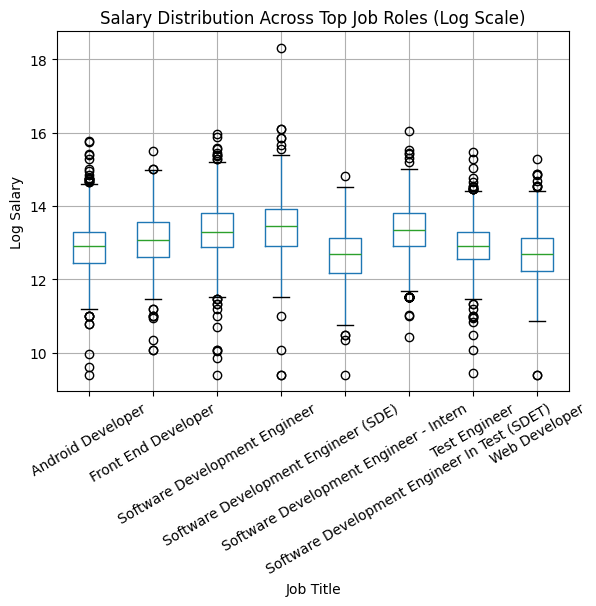

In [ ]:
import numpy as np
df['log_salary'] = np.log(df['Salary'])
top_roles = (
    df['Job Title']
    .value_counts()
    .head(8)
    .index
)

plt.figure(figsize=(12,6))
df[df['Job Title'].isin(top_roles)].boxplot(
    column='log_salary',
    by='Job Title',
    rot=30
)
plt.title("Salary Distribution Across Top Job Roles (Log Scale)")
plt.suptitle("")
plt.ylabel("Log Salary")
plt.show()

# Are salary differences across job roles statistically significant, or are they just random variation?

In [ ]:
from scipy import stats

# select top roles by frequency
top_roles = df['Job Title'].value_counts().head(6).index

anova_data = df[df['Job Title'].isin(top_roles)]
salary_groups = [
    anova_data[anova_data['Job Title'] == role]['log_salary']
    for role in top_roles
]
f_stat, p_value = stats.f_oneway(*salary_groups)
f_stat, p_value

(np.float64(166.35974588393537), np.float64(3.5824467689146485e-170))

A one-way ANOVA test was conducted to examine whether salary differences across major job roles are statistically significant.
The test produced an F-statistic of 166.36 and a p-value of < 0.001, indicating strong statistical significance.
Therefore, the null hypothesis was rejected, confirming that salary variations across job roles are not due to random chance.

# Feature Engineering & Advanced Grouping

In [ ]:
df['salary_band'] = pd.qcut(
    df['Salary'],
    q=3,
    labels=['Low', 'Medium', 'High']
)
band_by_role = (
    df.groupby(['Job Title', 'salary_band'], observed=True)
      .size()
      .unstack()
      .fillna(0)
)

band_by_role.head()

salary_band,Low,Medium,High
Job Title,,,
"""ORACLE DBA""",1.0,1.0,0.0
".NET Developer, Python",0.0,1.0,0.0
.NET/Android Developer,1.0,0.0,0.0
AEM Front End Developer - Intern,1.0,0.0,0.0
ASAP Software Development Engineer,0.0,0.0,1.0


Certain job roles have a higher concentration in the high salary band, indicating stronger earning potential compared to others.

In [ ]:
tier1 = ['Bangalore', 'Bengaluru', 'Mumbai', 'Delhi', 'Hyderabad', 'Pune', 'Chennai']

df['city_tier'] = df['Location'].apply(
    lambda x: 'Tier-1' if any(city in x for city in tier1) else 'Tier-2'
)
df.groupby('city_tier')['Salary'].median()

,Salary
city_tier,
Tier-1,500000.0
Tier-2,500000.0


Tier-1 median salary = 500,000

Tier-2 median salary = 500,000

Reason 1: Median hides distribution differences

Reason 2: Salary bands are more informative here

In [ ]:
band_by_city = (
    df.groupby(['city_tier', 'salary_band'], observed=True)
      .size()
      .unstack()
      .fillna(0)
)

band_by_city
band_by_city_pct = band_by_city.div(band_by_city.sum(axis=1), axis=0) * 100
band_by_city_pct

salary_band,Low,Medium,High
city_tier,,,
Tier-1,33.504112,34.142286,32.353602
Tier-2,34.990440,37.093690,27.915870


While median salaries across Tier-1 and Tier-2 cities appear similar, the salary band distribution reveals meaningful differences.
Tier-1 cities have a higher proportion of high-salary roles (≈32%) compared to Tier-2 cities (≈28%), indicating greater upside potential.
In contrast, Tier-2 cities are more concentrated in the medium salary band, suggesting more stable but limited compensation growth.

# Can we reasonably estimate salary using available features, and which factors matter most?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

X = df[['Rating', 'city_tier', 'Job Title', 'Salaries Reported']]
y = df['log_salary']

categorical_features = ['city_tier', 'Job Title']
numeric_features = ['Rating', 'Salaries Reported']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse

(0.57372607470426, np.float64(0.7465141860387966))

A baseline linear regression model was developed to predict log-transformed salary using job role, city tier, company rating, and reporting frequency.
The model achieved a mean absolute error of approximately 0.57 and an RMSE of 0.75, indicating reasonable predictive performance given the inherent variability in salary data.
The results suggest that while salary can be partially explained by observable features, significant variation remains due to unobserved factors such as individual skills and company-specific policies.

# SUMARRY
1. Salary distributions in the Indian software industry are highly skewed, with significant outliers.

2. Job role has a statistically significant impact on salary, as confirmed by ANOVA testing.

3. Tier-1 cities offer greater upside potential, with a higher proportion of high-paying roles.

4. Median salary alone is insufficient to capture compensation differences; distributional analysis provides deeper insight.

5. Predictive modeling shows that role and location are stronger salary predictors than company rating.